# **HMM**
Dataset used include
coinbase_premium_gap getting from CryptoQuant and OHLCV data getting from Alphavantage, hourly data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Load data
df = pd.read_csv("/content/full_market_data_with_indicators.csv", parse_dates=["datetime"])
df = df.sort_values("datetime").reset_index(drop=True)

# 1. Create cyclical time features
df['hour_sin'] = np.sin(2 * np.pi * df['datetime'].dt.hour/24)
df['hour_cos'] = np.cos(2 * np.pi * df['datetime'].dt.hour/24)

# 2. Select all numerical features for PCA
# Exclude datetime and any other non-numerical columns
features = [
    'coinbase_premium_gap',
    'coinbase_premium_gap_usdt_adjusted',
    'coinbase_premium_index',
    'coinbase_premium_index_usdt_adjusted',
    'open',
    'high',
    'low',
    'close',
    'volume',
    'sma',
    'rsi',
    'hour_sin',
    'hour_cos'  # our transformed time features
]

# 3. Standardize the features (important for PCA)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

# Impute NaN values with the mean of each column
imputer = SimpleImputer(strategy='mean') # Create an imputer instance
scaled_features = imputer.fit_transform(scaled_features) # Impute NaN values

# 4. Perform PCA
# Choose number of components (can adjust this)
n_components = min(4, len(features))
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(scaled_features)

# 5. Create DataFrame with the principal components
pca_df = pd.DataFrame(
    data=principal_components,
    columns=[f'PC{i+1}' for i in range(n_components)]
)

# 6. Optionally: Combine with original data
final_df = pd.concat([df, pca_df], axis=1)

# 7. Examine explained variance
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance:", sum(pca.explained_variance_ratio_))

Explained variance ratio: [0.40503967 0.18219814 0.12218109 0.10925391]
Total explained variance: 0.8186728154039988


In [ ]:
loadings = pca.components_

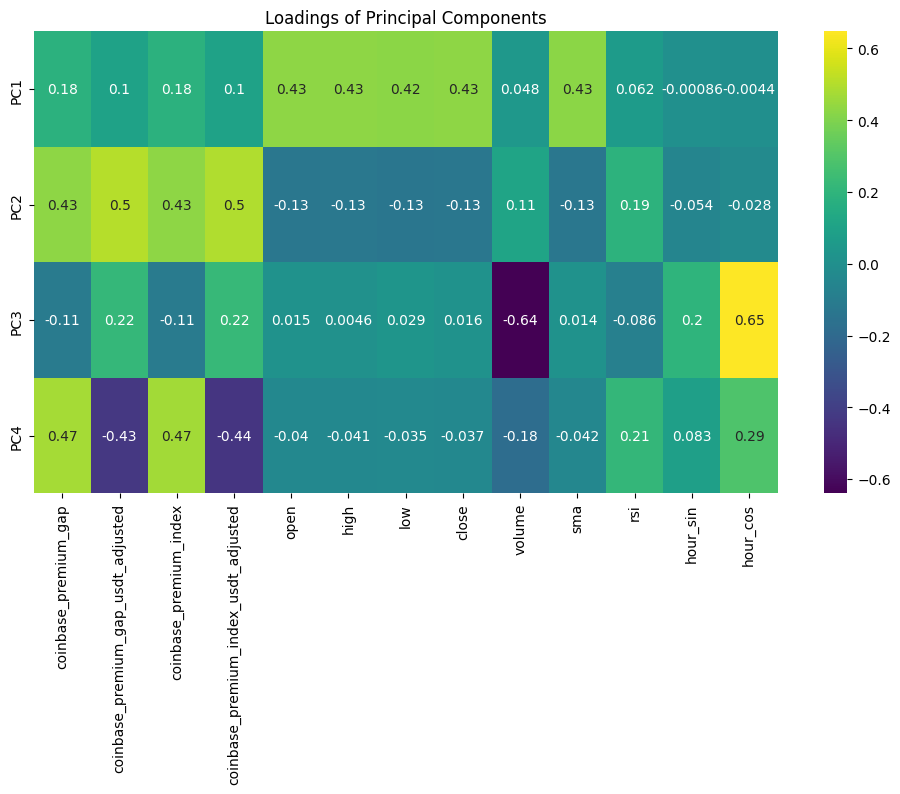

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame for loadings
loadings_df = pd.DataFrame(loadings, columns=features, index=[f'PC{i+1}' for i in range(n_components)])

# Plot a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(loadings_df, annot=True, cmap='viridis')
plt.title('Loadings of Principal Components')
plt.show()

# **HMM**

In [ ]:
pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 3.6 MB/s eta 0:00:00


In [ ]:
from hmmlearn import hmm
from xgboost import XGBClassifier

df["returns"] = df["close"].pct_change()
df = df.dropna()

# Train HMM to predict market regimes
scaler = StandardScaler()
hmm_features = ["coinbase_premium_gap", "coinbase_premium_index", "open", "high", "low", "close", "returns", "volume","sma","hour_cos"]
scaled = scaler.fit_transform(df[hmm_features])

model_hmm = hmm.GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000)
model_hmm.fit(scaled)
df["hmm_state"] = model_hmm.predict(scaled)  # Add HMM states as a feature


# **Train LSTM**


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

df["returns"] = df["close"].pct_change()
df = df.dropna()

# Example features (you can add more)
features = ["hmm_state", "coinbase_premium_gap", "coinbase_premium_index","open", "high", "low", "close", "volume", "rsi", "sma"]

# Scaling the data using MinMaxScaler for LSTM (LSTM is sensitive to scaling)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[features])

# Create sequences (look back window)
def create_sequences(data, window_size=45):
    x = []
    y = []
    for i in range(window_size, len(data)):
        x.append(data[i-window_size:i, :-1])  # Use all features except the target (close price)
        y.append(data[i, -1])  # Predict the next close price
    return np.array(x), np.array(y)

# Create sequences of 60 past time steps
X, y = create_sequences(scaled_data, window_size=60)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape the data for LSTM: (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# To prevent overfitting


In [ ]:
from tensorflow.keras import regularizers

# Build the LSTM model with regularization
model = Sequential()

# LSTM Layer with Dropout for regularization
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]),
               kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01))) # L2 Regularization
model.add(Dropout(0.2))

# LSTM Layer
model.add(LSTM(units=100, return_sequences=False,
               kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01)))  # L2 Regularization
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(units=1))  # Predicting next close price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - loss: 2.2565 - val_loss: 0.2209
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.1320 - val_loss: 0.0252
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 19s 96ms/step - loss: 0.0186 - val_loss: 0.0120
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 0.0081 - val_loss: 0.0060
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.0050 - val_loss: 0.0061
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - loss: 0.0043 - val_loss: 0.0049
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - loss: 0.0038 - val_loss: 0.0064
Epoch 9/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - loss: 0.0035 - val_loss: 0.0079
Epoch 10/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.0034 - val_loss: 0.0062
Epoch 11/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 12/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 19s 92ms

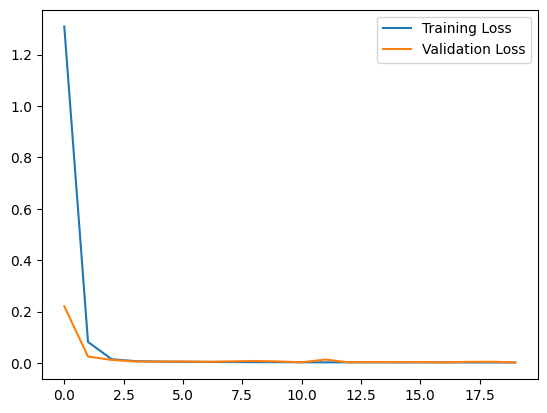

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Optionally, you can plot the training history to check for overfitting
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


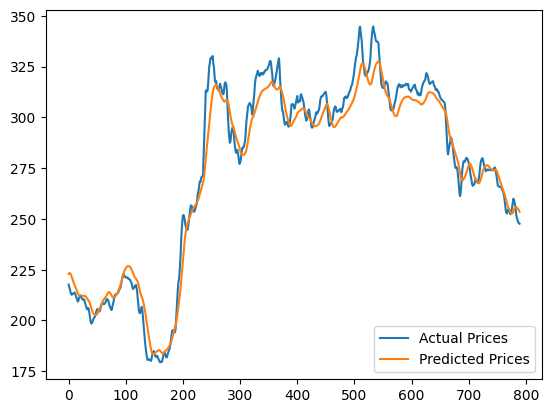

In [ ]:
# Predict the stock price on test data
y_pred = model.predict(X_test)

# Rescale the features and the target variable separately
# Extract the last feature (usually 'close' for stock prediction)
# X_test_rescaled = scaler.inverse_transform(X_test[:, -1, :-1])  # Only features - Original line causing the error
num_features = X_test.shape[2]  # Get the number of features used in the LSTM model (6)
X_test_2D = X_test[:, -1, :].reshape(-1, num_features) # Reshape to 2D for inverse_transform


# Create a dummy array with all original features
dummy_array = np.zeros((X_test_2D.shape[0], len(features)))

# Fill the dummy array with the relevant features from X_test_2D
dummy_array[:, :num_features] = X_test_2D

# Now use inverse_transform on the dummy array
X_test_rescaled = scaler.inverse_transform(dummy_array)[:, :num_features]

# Rescale the predicted values and actual values by appending them to the features
y_pred_rescaled = scaler.inverse_transform(np.hstack((X_test_rescaled, y_pred.reshape(-1, 1))))[:, -1]
# Original: y_test_rescaled = scaler.inverse_transform(np.hstack((X_test_rescaled, y_test.reshape(-1, 1))))[:, -1]
y_test_rescaled = scaler.inverse_transform(np.hstack((X_test_rescaled, y_test[:len(y_pred)].reshape(-1, 1))))[:, -1] # Fix dimension mismatch


# Plot the actual vs predicted values
plt.plot(y_test_rescaled, label='Actual Prices')
plt.plot(y_pred_rescaled, label='Predicted Prices')
plt.legend()
plt.show()

# **Hybrid LSTM+XGBoost**
**LSTM: Forecasts future market trends — for example, predicting future close prices, returns, or price directions.**  
**XGBoost: Takes the LSTM prediction (and maybe other features) as input, and classifies what action to take: Buy, Sell, or Hold**

In [ ]:
# Construct DataFrame for XGBoost
lstm_predicted_returns = np.append([0], np.diff(y_pred_rescaled) / y_pred_rescaled[:-1])

xgb_features = pd.DataFrame({
    "lstm_pred_return": lstm_predicted_returns.flatten(),  # can add other engineered features
})

# Define target again (Buy/Sell/Hold)
threshold = 0.005
target = np.zeros_like(lstm_predicted_returns.flatten())
target[lstm_predicted_returns.flatten() > threshold] = 1   # Buy
target[lstm_predicted_returns.flatten() < -threshold] = -1 # Sell


In [ ]:
label_map = {-1: 0, 0: 1, 1: 2}
target_mapped = pd.Series(target).map(label_map)


In [ ]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    objective="multi:softmax",
    num_class=3,
    random_state=42
)

model_xgb.fit(xgb_features, target_mapped)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

# **Test Signal**

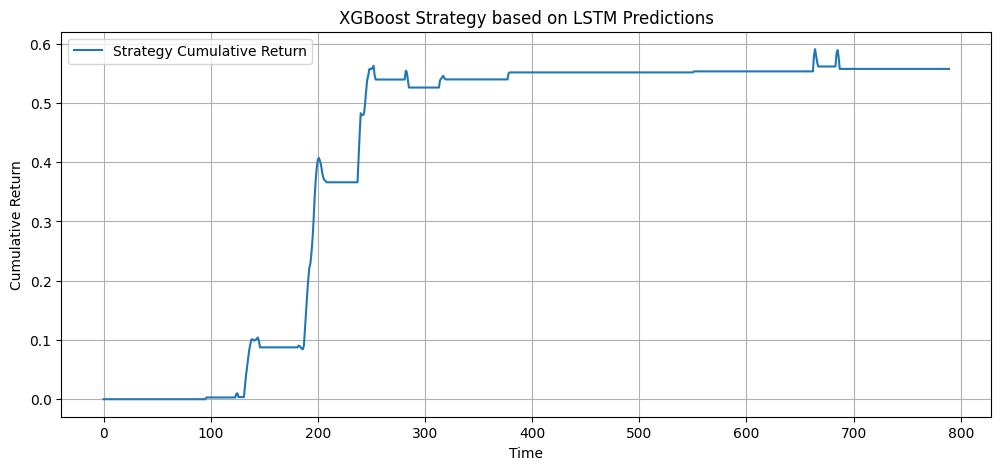

Sharpe Ratio: 2.37
Max Drawdown: -2.92%
Trading Frequency: 10.76% (~27.1 trades/year)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

# --- Step 1: Predict with XGBoost model ---
predictions = model_xgb.predict(xgb_features)

# --- Step 2: Remap prediction labels ---
# You used label_map = {-1: 0, 0: 1, 1: 2}
inverse_label_map = {0: -1, 1: 0, 2: 1}
signals = np.vectorize(inverse_label_map.get)(predictions)

# --- Step 3: Calculate strategy returns based on predicted signals ---
# Get the actual test returns
actual_returns = np.append([0], np.diff(y_test_rescaled) / y_test_rescaled[:-1])

# Make sure lengths match
signals = signals[:len(actual_returns)]

# Shift signal so that we execute at the next timestep
shifted_signals = np.roll(signals, 1)
shifted_signals[0] = 0  # Neutral at the start

strategy_returns = shifted_signals * actual_returns

# --- Step 4: Compute metrics ---

# Cumulative returns
cumulative_returns = np.cumprod(1 + strategy_returns) - 1

# Sharpe Ratio
sharpe_ratio = np.mean(strategy_returns) / (np.std(strategy_returns) + 1e-9) * np.sqrt(252)

# Max Drawdown
cumulative_curve = (1 + strategy_returns).cumprod()
rolling_max = np.maximum.accumulate(cumulative_curve)
drawdown = cumulative_curve / rolling_max - 1
max_drawdown = drawdown.min()

# Trading Frequency
trading_actions = np.count_nonzero(shifted_signals)
trading_frequency = trading_actions / len(shifted_signals)
trades_per_year = trading_frequency * 252

# --- Step 5: Plot ---
plt.figure(figsize=(12,5))
plt.plot(cumulative_returns, label='Strategy Cumulative Return')
plt.title("XGBoost Strategy based on LSTM Predictions")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid()
plt.show()

# --- Step 6: Print Results ---
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Trading Frequency: {trading_frequency:.2%} (~{trades_per_year:.1f} trades/year)")
